run for 10 years to get to steady state and then run the new drought conditions in this file and the new flood conditions in the sample topo flood file. 


In [29]:

# PYTHON IMPORTS
import numpy as np  # basic python library
import matplotlib.pyplot as plt  # For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel
import cv2
from random import randint
import math

# LANDLAB COMPONENTS
from landlab.components import DepressionFinderAndRouter  # Pit filling
from landlab.components import PriorityFloodFlowRouter  # Flow routing
from landlab.components import FlowAccumulator  # FlowAccumulator
from landlab.components import ChannelProfiler
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser
from landlab.components import SpatialPrecipitationDistribution
from landlab.components import OverlandFlow
from landlab.components import PrecipitationDistribution

# SPACE COMPONENTS
from landlab.components import Space  # SPACE model
# basically SPACE 2.0 -- use this
from landlab.components import SpaceLargeScaleEroder
# calculates the amount of erosion at each node
from landlab.components import FastscapeEroder
# replaces pits with shallow gradients for draining
from landlab.components import SinkFillerBarnes

# LANDLAB UTILITIES
from landlab import RasterModelGrid  # Grid utility
from landlab import imshow_grid  # For plotting results
from landlab.io import read_esri_ascii  # to read in an ascii file
# to read in the header of the ascii file
from landlab.io import read_asc_header
from landlab.io import write_esri_ascii
from landlab.utils.flow__distance import calculate_flow__distance

%matplotlib inline


In [30]:
# GRID SPECS
ncols = 84
nrows = 80
cellsize = 100

# RETRIEVE TOPO FROM ASCII
topo_dem = "alex_ascii_100.txt"  # the name of the ascii file
topo_path = topo_dem
topo_header = read_asc_header(open(topo_path, 'r'))
# generating the new grid
(mg, z) = read_esri_ascii(topo_path, name='topographic__elevation', halo=0)

# FIND OUTLET
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()
min_topo_ID = open_nodes[min_topo]
outlet_id = mg.set_watershed_boundary_condition_outlet_id(
    min_topo_ID, mg['node']['topographic__elevation'], -9999)
outlet_id = min_topo_ID

# HYDROLOGICALLY FILL THE aDEM
# creating an instance of sinkfillerbarnes
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False)
sfb.run_one_step()  # This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

# CLOSE BOUNDARIES
mg.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True, left_is_closed=True, right_is_closed=True, top_is_closed=True)

# # PLOT THE TOPOGRAPHY
# figelev = plt.figure()#Instantiate figure as empty plot
# plot = plt.subplot()#Instantiate subplot as empty plot
# imshow_grid(mg, 'topographic__elevation', plot_name='Sample Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
# fname = "final_plots/sample_INITIAL_TOPO.png"
# figelev.savefig(fname, dpi='figure', format=None)

# ADDING SOIL FIELD
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  # Set 2 m of initial soil depth at core nodes

# ADDING BEDROCK FIELD
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - \
    mg.at_node['soil__depth']

# SETTING UP OUTLET ID
mg.at_node['bedrock__elevation'][outlet_id] = 0
mg.at_node['topographic__elevation'][outlet_id] = 0
mg.at_node['soil__depth'][outlet_id] = 0
print(outlet_id)

# ADDING SURFACE WATER DEPTH
mg.add_zeros('surface_water__depth', at='node')

# ADDING SURFACE WATER DISCHARGE
mg["node"]["surface_water__discharge"] = np.zeros(mg.number_of_nodes)


85


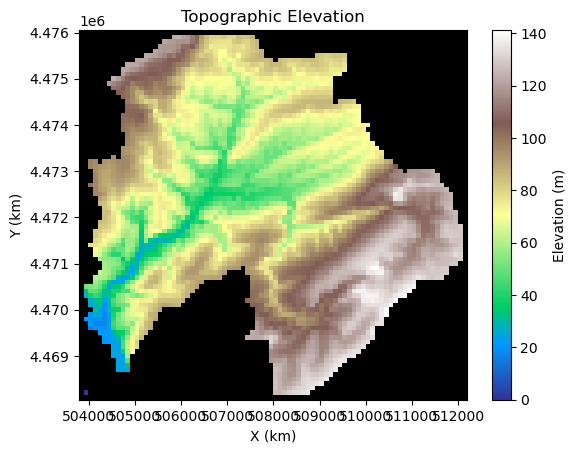

In [31]:
# PLOT THE TOPOGRAPHY
figelev = plt.figure()  # Instantiate figure as empty plot
plot = plt.subplot()  # Instantiate subplot as empty plot


imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name='Elevation',
            var_units=r'm', grid_units=('km', 'km'), cmap='terrain', color_for_background=None)


In [32]:
# PARAMETERS FOR SPACE
K_sed = 0.0001  # Lists for saving data01 # ADDED A 0 HERE 4/11
K_sp = 0.001
K_br = 0.0000001
F_f = 0.5
phi = 0.1
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 50  # 1
sp_crit_br = 100  # 1.5

# SET MODEL TIME PARAM
sp_timestep = 1/365
# run_time = 100 #years
uplift_rate = .001  # m/year
uplift_per_timestep = uplift_rate * sp_timestep
soil_rate = .00000000002739  # m/year
soil_per_per_timestep = .001*sp_timestep  # 0.00000273973 #1mm/year into m/hr


# INSTANTIATING COMPONENTS
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out=True)

fa = FlowAccumulator(mg, flow_director='D8')

df = DepressionFinderAndRouter(mg, pits='flow__sink_flag', reroute_flow=True)

fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)

sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br,
                           discharge_field='surface_water__discharge')  # K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br
# Instantiate SPACE model with chosen parameters as sp
# sp = SpaceLargeScaleEroder(grid=mg, K_sed= K_sed, K_br=K_br, F_f=F_f, phi=phi, H_star=H_star, v_s=v_s, m_sp=m_sp,  n_sp=n_sp, sp_crit_sed=sp_crit_sed, sp_crit_br=sp_crit_br, discharge_field='surface_water__discharge')# K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br

expweath = ExponentialWeatherer(mg)

DDdiff = DepthDependentDiffuser(mg)

expweath.calc_soil_prod_rate()

np.allclose(mg.at_node['soil_production__rate'][mg.core_nodes], .0001)

# RUNNING FSC FOR 1 YEAR TO IDENTIFY CHANNELS
# fa.run_one_step()
# df.map_depressions()
# fsc.run_one_step(1)


# SET UP CHANNEL PROFILER AND RUN
# profiler = ChannelProfiler(mg,number_of_watersheds=1,minimum_channel_threshold=0,main_channel_only=True)
# profiler.run_one_step()
# profiler.data_structure.keys() #is [101]
# profiler.data_structure[1452].keys()
# profiler.data_structure[1452][(1452,9687)]["ids"] #produces array of id values for the channel


False

CHANGE VISUALS SETTING UP

# PLOT THE TOPOGRAPHY 
figelev = plt.figure()#Instantiate figure as empty plot
#plot = plt.subplot()#Instantiate subplot as empty plot
extent = [0,6000,0,6000]

t = imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
t.set_extent(extent)


In [33]:
# SETTING UP OLD TOPO
mg.add_zeros('node', 'old__topo')


mg.add_zeros('node', 'change__topo')
mg.add_zeros('node', 'change__water')


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [34]:
# VARIABLES FOR OVERLAND FLOW AND PRECIP

# OVERALL
model_total_years = 1  # (yrs)
rain_total_t = 15  # 8760 *1#(hrs) 3 make this for spring season actually
model_total_t = 8760 * model_total_years  # (hrs)
model_total_days = model_total_years*365

# WINTER --- 91.25 days = 2190 hrs each season
winter_stm_avg_dur = 24
winter_interstm_avg_dur = 336*2
winter_stm_avg_int = .081026

# SPRING
spring_stm_avg_dur = 24
spring_interstm_avg_dur = 500
spring_stm_avg_int = .081026

# SUMMER
summer_stm_avg_dur = 24
summer_interstm_avg_dur = 200
summer_stm_avg_int = .081026
# FALL
fall_stm_avg_dur = 24
fall_interstm_avg_dur = 336
fall_stm_avg_int = .081026


In [35]:
# INITIALIZE RAIN COMPONENTS
of = OverlandFlow(mg, steep_slopes=True)
rain = PrecipitationDistribution(mg, mean_storm_duration=spring_stm_avg_dur, mean_interstorm_duration=spring_interstm_avg_dur,
                                 mean_storm_depth=spring_stm_avg_int, total_t=rain_total_t, delta_t=1.0)

# ARRAYS FOR STORING DATA
storm_time_data = []
interstorm_time_data = []
storm_amt_data = []


In [36]:
# LOOP ITERATION VARIABLES
model_elapsed_time = 0
model_elapsed_years = 0
model_total_years = 29
model_time = 0

model_elapsed_days = 0

start_year = 4
# SEASONONAL LOOPING
winter_t_hrs = 91 * 24
winter_elapsed_hrs = 0

spring_t_hrs = 91 * 24
spring_elapsed_hrs = 0

summer_t_hrs = 91 * 24
summer_elapsed_hrs = 0

fall_t_hrs = 91 * 24
fall_elapsed_hrs = 0

title_yr = 1
num_topo = 0
num_sed = 0
old_done = False
# RUN THE MODEL
while model_elapsed_years < model_total_years:  # over the years
    for x in range(1, 5):
        if x == 1:  # it is winter
            stm_avg_dur = winter_stm_avg_dur
            interstm_avg_dur = winter_interstm_avg_dur
            stm_avg_int = winter_stm_avg_int
            t_hrs = winter_t_hrs
            elapsed_hrs = 0
            model_hrs = winter_t_hrs
            print("---------IN WINTER-------Year " +
                  str(model_elapsed_years)+"------------")

        elif x == 2:  # it is spring
            stm_avg_dur = spring_stm_avg_dur
            interstm_avg_dur = spring_interstm_avg_dur
            stm_avg_int = spring_stm_avg_int
            t_hrs = spring_t_hrs
            print("---------IN SPRING-------Year " +
                  str(model_elapsed_years)+"------------")

        elif x == 3:
            stm_avg_dur = summer_stm_avg_dur
            interstm_avg_dur = summer_interstm_avg_dur
            stm_avg_int = summer_stm_avg_int
            t_hrs = summer_t_hrs
            print("---------IN SUMMER-------Year " +
                  str(model_elapsed_years)+"------------")

        elif x == 4:
            stm_avg_dur = fall_stm_avg_dur
            interstm_avg_dur = fall_interstm_avg_dur
            stm_avg_int = fall_stm_avg_int
            t_hrs = fall_t_hrs
            print("---------IN FALL-------Year " +
                  str(model_elapsed_years)+"------------")

        if model_elapsed_years == 1:
            mg.at_node["old__topo"][:] = mg.at_node["topographic__elevation"]

        # INITIALIZE COMPONENTS FOR THE SEASON
        mg.delete_field(loc='grid', name='rainfall__flux')
        rain = PrecipitationDistribution(mg, mean_storm_duration=stm_avg_dur,
                                         mean_interstorm_duration=interstm_avg_dur, mean_storm_depth=stm_avg_int, total_t=t_hrs, delta_t=1.0)
        of = OverlandFlow(mg, steep_slopes=True)

        # ARRAYS FOR STORING DATA
        stm_dur = []
        interstm_dur = []
        num_stm = 0
        int_pattern = []

        # GET STORM INFO FIRST
        first = False
        second = False
        rain.seed_generator(seedval=1)
        for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs

            for x in range(int(storm_t)):
                # add intensity for duration of the storm
                int_pattern.append(mg.at_grid['rainfall__flux'])

            # print(rain.elapsed_time)

            for x in range(int(interstorm_t)):
                # eno intensity during interstorm period
                int_pattern.append(int(0.0))

            stm_dur.append(storm_t)
            interstm_dur.append(interstorm_t)
            num_stm += 1
            storm_amt_data.append(num_stm)
        if x == 1:
            first_stm_hydro_t = stm_dur[0] + interstm_dur[0]
            print(first_stm_hydro_t)
            print("length of int_pattern " + str(len(int_pattern)))

        elapsed_hrs = 0
        while elapsed_hrs <= len(int_pattern):
            of.dt = of.calc_time_step()
            # adding uplift to the bedrock
            mg.at_node['bedrock__elevation'][mg.core_nodes] += (
                uplift_rate*(1/8760)*of.dt)
            # adding uplift to the bedrock
            mg.at_node['bedrock__elevation'][mg.core_nodes] -= (
                soil_rate*(1/8760)*of.dt)
            # adding uplift to the bedrock
            mg.at_node['soil__depth'][mg.core_nodes] += (
                soil_rate*(1/8760)*of.dt)
            # adding uplift to the bedrock
            mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_rate * \
                (1/8760)*of.dt

            DDdiff.run_one_step((1/8760)*of.dt)
            of.rainfall_intensity = int_pattern[int(
                elapsed_hrs)]  # *(1.15741*10**-8)
            of.run_one_step(dt=of.dt)

            elapsed_hrs += of.dt
            # print(of.rainfall_intensity)
            # fr.run_one_step()
            # sp.run_one_step(dt = of.dt/8760)
            # print("timestep =" + str(of.dt))
            # print("elapsed time = " + str(elapsed_hrs))
            # print("length of int_pattern " + str(len(int_pattern)))

            title_yr += 1
        fr.run_one_step()
        sp.run_one_step(dt=0.25)
        elapsed_hrs = 0
        if model_elapsed_years == start_year & old_done == False:  # save current topo as old topo
            mg.at_node["old__topo"][:] = mg.at_node["topographic__elevation"]
            old_done = True
        elif model_elapsed_years <= start_year & old_done == True:
            {}  # do nothing
        elif model_elapsed_years > start_year:
            mg.at_node["change__topo"][:] = (
                mg.at_node["topographic__elevation"] - mg.at_node['old__topo'])
            mg.at_node['change__topo'][outlet_id] = mg.at_node['change__topo'][outlet_id+1]

            figelev = plt.figure()  # Instantiate figure as empty plot
            plot = plt.subplot()  # Instantiate subplot as empty plot
            imshow_grid(mg, 'sediment__flux', vmin=-2E-10, vmax=2E-10, var_name='Sediment Flux ($m^3$)',
                        grid_units=('m', 'm'), cmap='terrain', color_for_background=None)
            plot.set_xticklabels(
                [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
            plot.set_yticklabels(
                [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
            fname = "exp/vids/base_alex_sed_video/alex_base_sed_flux_" + \
                str(num_sed) + "_"+".png"
            figelev.savefig(fname, dpi='figure', format=None)
            plt.close(figelev)
            num_sed += 1

            figelev = plt.figure()  # Instantiate figure as empty plot
            plot = plt.subplot()  # Instantiate subplot as empty plot
            imshow_grid(mg, 'change__topo', vmin=-.3, vmax=.3, var_name='Elevation Change',
                        var_units=r'm', grid_units=('m', 'm'), cmap='terrain', color_for_background=None)
            plot.set_xticklabels(
                [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
            plot.set_yticklabels(
                [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
            fname = "exp/vids/base_alex_topo_video/alex_base_change_topo_" + \
                str(num_topo) + "_yrs"+".png"
            figelev.savefig(fname, dpi='figure', format=None)
            plt.close(figelev)
            num_topo += 1

    # if model_elapsed_years == start_year:  # save current topo as old topo
    #     mg.at_node["old__topo"][:] = mg.at_node["topographic__elevation"]
    # if model_elapsed_years > start_year:
    #     mg.at_node["change__topo"][:] = (
    #         mg.at_node["topographic__elevation"] - mg.at_node['old__topo'])
    #     mg.at_node['change__topo'][outlet_id] = mg.at_node['change__topo'][outlet_id+1]

        # PLOT THE TOPOGRAPHY CHANGE & save
        # figelev = plt.figure()#Instantiate figure as empty plot
        # plot = plt.subplot()#Instantiate subplot as empty plot
        # imshow_grid(mg,'change__topo', var_name = 'Elevation Change', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        # plot.set_xticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000, 9000 ])
        # plot.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000 ])
        # fname = "exp/alex_base_10yr/alex_base_10yr_change_topo"+ str(model_elapsed_years) +"_yrs"+".png"
        # figelev.savefig(fname, dpi='figure', format=None)
        # plt.close(figelev)

        # figelev = plt.figure()#Instantiate figure as empty plot
        # plot = plt.subplot()#Instantiate subplot as empty plot
        # imshow_grid(mg,'topographic__elevation', var_name = 'Elevation Change', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        # plot.set_xticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000, 9000 ])
        # plot.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000 ])
        # fname = "exp/alex_base_10yr/alex_base_10yr_topo"+ str(model_elapsed_years) +"_yrs"+".png"
        # figelev.savefig(fname, dpi='figure', format=None)
        # plt.close(figelev)

        # figelev = plt.figure()#Instantiate figure as empty plot
        # plot = plt.subplot()#Instantiate subplot as empty plot
        # imshow_grid(mg,'sediment__flux', var_name = 'Sediment Flux ($m^3$)', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        # plot.set_xticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000, 9000 ])
        # plot.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000 ])
        # fname = "exp/alex_base_10yr/alex_base_10yr_sed_flux"+ str(model_elapsed_years) +"_yrs"+".png"
        # figelev.savefig(fname, dpi='figure', format=None)
        # plt.close(figelev)
        # title_yr+=1

    model_elapsed_years += 1


---------IN WINTER-------Year 0------------
---------IN SPRING-------Year 0------------
---------IN SUMMER-------Year 0------------
---------IN FALL-------Year 0------------
---------IN WINTER-------Year 1------------
---------IN SPRING-------Year 1------------
---------IN SUMMER-------Year 1------------
---------IN FALL-------Year 1------------
---------IN WINTER-------Year 2------------
---------IN SPRING-------Year 2------------
---------IN SUMMER-------Year 2------------
---------IN FALL-------Year 2------------
---------IN WINTER-------Year 3------------
---------IN SPRING-------Year 3------------
---------IN SUMMER-------Year 3------------
---------IN FALL-------Year 3------------
---------IN WINTER-------Year 4------------
---------IN SPRING-------Year 4------------
---------IN SUMMER-------Year 4------------
---------IN FALL-------Year 4------------
---------IN WINTER-------Year 5------------


/tmp/ipykernel_105529/290203635.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(
/tmp/ipykernel_105529/290203635.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(
/tmp/ipykernel_105529/290203635.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(
/tmp/ipykernel_105529/290203635.py:167: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(


---------IN SPRING-------Year 5------------
---------IN SUMMER-------Year 5------------
---------IN FALL-------Year 5------------
---------IN WINTER-------Year 6------------
---------IN SPRING-------Year 6------------
---------IN SUMMER-------Year 6------------
---------IN FALL-------Year 6------------
---------IN WINTER-------Year 7------------
---------IN SPRING-------Year 7------------
---------IN SUMMER-------Year 7------------
---------IN FALL-------Year 7------------
---------IN WINTER-------Year 8------------
---------IN SPRING-------Year 8------------
---------IN SUMMER-------Year 8------------
---------IN FALL-------Year 8------------
---------IN WINTER-------Year 9------------
---------IN SPRING-------Year 9------------
---------IN SUMMER-------Year 9------------
---------IN FALL-------Year 9------------
---------IN WINTER-------Year 10------------
---------IN SPRING-------Year 10------------
---------IN SUMMER-------Year 10------------
---------IN FALL-------Year 10---------

grid_fields_to_save = ["topographic__elevation"]

fname ="alex_reg_int_topo.txt"
# r"C:\Users\gsbir\Documents\EES_393"  + "\\Export\\" + 
write_esri_ascii(fname, mg, grid_fields_to_save)

In [37]:
outlet_node_to_sample = 1769
outlet_link_to_sample = mg.links_at_node[outlet_node_to_sample][3]
print(outlet_link_to_sample)
upstream_node_to_sample = 2278
upstream_link_to_sample = mg.links_at_node[upstream_node_to_sample][3]
print(upstream_link_to_sample)
midstream_node_to_sample = 2874
midstream_link_to_sample = mg.links_at_node[midstream_node_to_sample][3]
print(midstream_link_to_sample)


3428
4435
5612


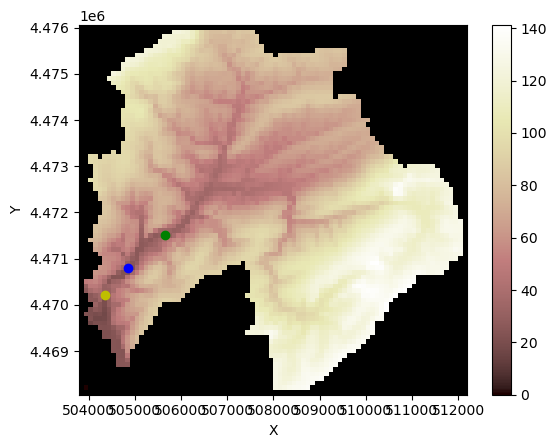

In [38]:


plt.figure(1)
imshow_grid(mg, z)  # plot the DEM
plt.plot(mg.node_x[outlet_node_to_sample],
         mg.node_y[outlet_node_to_sample], "yo")
plt.plot(mg.node_x[upstream_node_to_sample],
         mg.node_y[upstream_node_to_sample], "bo")
plt.plot(
    mg.node_x[midstream_node_to_sample], mg.node_y[midstream_node_to_sample], "go"
)
